$\textbf{Empirical Exercises for Week I}$

$\textit{GARCH Estimation for Asset Returns}$

In the following code, read into the workspace the spreadsheet giving data from 16 Chinese banks, the offshore and on shore rates and the indices of Global Economic Uncertainty.
You will need the m file rangefun.m in your workspace since this program converts daily data for open, high, low and closing share prices to estiamtes of daily Range Volatility.  

In [1]:
TAB = readtable('China_All_Data.xls');
date1 = TAB(4:end,1);
Controls = TAB(4:end,2:17);
% RangeVol = TAB(:,18:34);
SpotSpread = TAB(4:end,35:36);
SharePrice = TAB(4:end,37:end);
[rshare, cshare] = size(SharePrice);


date1 = table2array(date1);
Controls = table2array(Controls);
% RangeVol = table2array(RangeVol);
% RangeVol = fillmissing(RangeVol, 'previous');
SharePrice = table2array(SharePrice);
SharePrice = SharePrice(2:end,:);
index1 = 1:4:cshare;
OpenPrice = SharePrice(:,index1);
index2 = 2:4:cshare;
HighPrice = SharePrice(:,index2);
index3 = 3:4:cshare;
LowPrice = SharePrice(:,index3);
index4 = 4:4:cshare;
ClosePrice = SharePrice(:,index4);
SpotSpread = table2array(SpotSpread);
[rRange, cRange] = size(ClosePrice);
for i = 1:cRange,
   Data =  [OpenPrice(:,i) HighPrice(:,i) LowPrice(:,i) ClosePrice(:,i)];
   RangeVol(:,i) = rangefun(Data);
end
Return = diff(log(ClosePrice));
[rRange, cRange] = size(RangeVol); 
numseries = cRange;
numlags = 3;
RangeVol1 = normalize(RangeVol,'range');
Controls1 = normalize(Controls,'range');


In [2]:
who


Your variables are:

ClosePrice  Controls1   HighPrice   OpenPrice   RangeVol1   SharePrice  TAB         cshare      i           index2      index4      numseries   rshare      
Controls    Data        LowPrice    RangeVol    Return      SpotSpread  cRange      date1       index1      index3      numlags     rRange      




The Rangevol matrix is the matrix of the dependenet variables, the Controls are the indices of global uncertainty, and the returns are the log first-differenced daily closeing share prices.

Let's estimate a GARCH(1,1) for the last return in the spreadsheet, it is that of the offshore Hong Kong spot rate.

In [3]:
Mdl1 = garch(1,1);
[EstMdl1,EstParamCov1,logL1,info1] = estimate(Mdl1,Return(:,end));
[v, yhat] = simulate(EstMdl1,length(Return));


> In garch/estimate (line 758)
 
    GARCH(1,1) Conditional Variance Model (Gaussian Distribution):
 
                 Value      StandardError    TStatistic      PValue   
                ________    _____________    __________    ___________

    Constant       2e-07     1.0198e-07        1.9612          0.04985
    GARCH{1}      0.8901      0.0026544        335.33                0
    ARCH{1}     0.070599      0.0028756        24.551      4.2043e-133




We have estiamted a GARCH process for the off-shore daily change in the exchagne rate.  The estimate shows that there is a lot of intertia in the volatility, with a persistence parameter of .89.

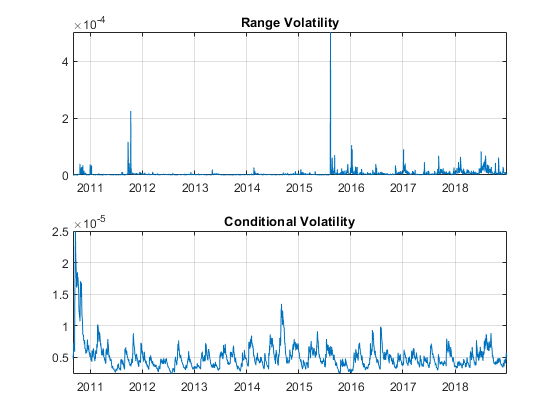

In [4]:
subplot(211); plot(date1(2:end,:), RangeVol(:,end)); ...
    title('Range Volatility'); axis tight; grid;...
    subplot(212); plot(date1(3:end,:), v); ...
    title('Conditional Volatility'); grid; axis tight;


We plot above the calulated Range Volatlity from daily opening-high-low-cloasing data with the conditioal volatlity obtained by the GARCH estimation.  Note the differences.

Repeat this for other variables, see how well the Range volatlity and the conditional GARCH volatility measures follow each other.

Now lets estimate an EGARCH model.  We discussed this EGARCH model in Week 9 of Financial Econometrics.

In [5]:
Mdl2 = egarch(1,1);
[EstMdl2,EstParamCov2,logL2,info2] = estimate(Mdl2,Return(:,end));
[v2, yhat2] = simulate(EstMdl2,length(Return));

 
    EGARCH(1,1) Conditional Variance Model (Gaussian Distribution):
 
                    Value      StandardError    TStatistic      PValue  
                   ________    _____________    __________    __________

    Constant        -0.5279       0.070457       -7.4925      6.7549e-14
    GARCH{1}        0.95613       0.005798        164.91               0
    ARCH{1}        0.098073       0.010053        9.7553      1.7516e-22
    Leverage{1}    0.033303      0.0067853         4.908      9.1998e-07




We see even higher persistence effect in the EGARCH model as well as a significant "leverage" effect.  The leverage effect captures the face that negative surprise returns have stronger effects on volatility than positive surprise returns.

Lets plot the two conditional volatility measures together to see how they contrast with the Range volatility measure.

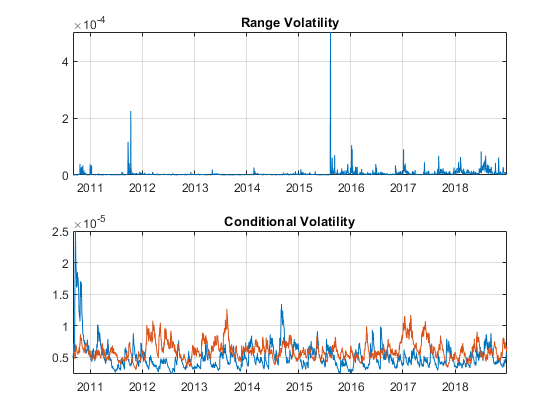

In [6]:
subplot(211); plot(date1(2:end,:), RangeVol(:,end)); ...
    title('Range Volatility'); axis tight; grid;...
    subplot(212); plot(date1(3:end,:), [v v2]); ...
    title('Conditional Volatility'); grid; axis tight;

Compare the differences of the GARCH and EGARCH conditional volatilities for other assets.

$\textit{VARX Estimation for Share Price Volatilities}$

Now we will estimate a VAR model for the system, 16 banks and the off-shore HK exchange market as the "state variables" with the Economic Policy Uncertainty indices as the "controls".
As you see below, we first "normalize" the RangevVol and Controls between zero and one.  Then we adjust them to the number of lags for y and x. 
We specify the model as a VARM (Var model) for the number of series and lags
The estimate function gives hte estimated model parameters for y and x.
The value h gives the Granger causality test for each of the state variables on each other. 
Decomp gives the forcast error variance decomposition for state variables  Basically for horizon 12, we show how much of the total error variance is explained by the shocks to each of the state variables.  It is an out-of-sample Granger causality test.


In [8]:
RangeVol1 = normalize(RangeVol,'range');
Controls1 = normalize(Controls,'range');
y = RangeVol1(numlags+1:end,:);
x = Controls1(numlags+1:end,:);
Mdl = varm(numseries,numlags);
[EstMdl, EstSE, logL, E] = estimate(Mdl, y,'X',x, 'Display', 'full');
[h,Pval] = gctest(EstMdl, 'Test', 'f','Cause', 1:cRange); 
[Decomp] = fevd(EstMdl,'Method', 'generalized');
Decomp1 = Decomp(12,:,:);
Decomp1 = reshape(Decomp1, cRange, cRange);
Decomp2 = Decomp1 - diag(diag(Decomp1));
Outward = sum(Decomp2);
Inward =  sum(Decomp2,2)';
Net = Outward - Inward;


 
   <strong>AR-Stationary 17-Dimensional VARX(3) Model with 16 Predictors</strong>
 
    Effective Sample Size: 2165
    Number of Estimated Parameters: 1156
    LogLikelihood: 80889
    AIC: -159466
    BIC: -152900
 
                       Value       StandardError    TStatistic      PValue   
                    ___________    _____________    __________    ___________

    Constant(1)         0.12275       0.017574          6.9847     2.8557e-12
    Constant(2)        0.041475       0.022343          1.8563       0.063413
    Constant(3)         0.18117       0.022279           8.132     4.2241e-16
    Constant(4)        0.088292       0.019005          4.6458     3.3884e-06
    Constant(5)         0.14298       0.026278           5.441      5.298e-08
    Constant(6)           0.192       0.015553          12.345     5.2098e-35
    Constant(7)        0.098891       0.016071          6.1535     7.5801e-10
    Constant(8)         0.23575       0.017815          13.233     5.6464e-40

From the 12-period Forecast Error Variance Decomposition we can find the net outward connnectedness of each of the variables, which variables spillover more to the rest of the system more than others and which variables are more inwardly dependent.


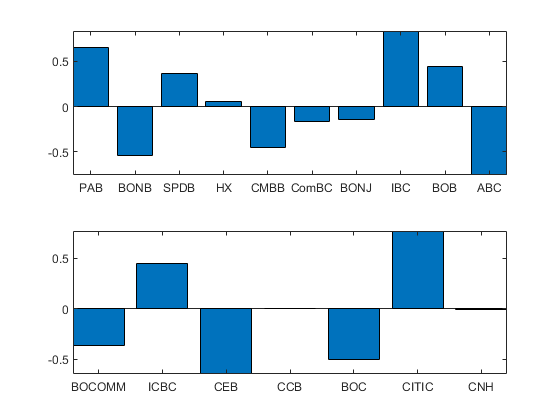

In [9]:
subplot(211); ...
bar(Net(1:10)); axis([1,17, -1,1]);axis tight;...
names ={'PAB'; 'BONB'; 'SPDB'; 'HX'; 'CMBB'; 'ComBC'; 'BONJ'; 'IBC'; 'BOB'; 'ABC';...
    'BOCOMM'; 'ICBC'; 'CEB'; 'CCB'; 'BOC'; 'CITIC'; 'CNH'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
subplot(212); ...
bar(Net(11:17)); axis([1,7,-1,1]); axis tight;...
names1 = {'BOCOMM'; 'ICBC'; 'CEB'; 'CCB'; 'BOC'; 'CITIC'; 'CNH'}; ...
set(gca,'xtick',[1:7],'xticklabel',names1);

For the China example, we see that for full-sample estimation the most important banks are IBC and CITIC.  Question:  if we divided the sample in half will be get the same resutls?